# Baseline 

## Automated Weed Detection and Removal in Agricultural Fields Using oneAPI Toolkit

### Introduction 
Automated Weed Detection is a project aimed at detecting and classifying crop fields and weed patches in agricultural imagery using computer vision techniques. The project utilizes an auto mixed precision ResNet model for inference, achieving an accuracy of 98.46% in distinguishing between crop and weed. The ResNet model is optimized with OpenVINO toolkit to perform inference on CPU in real-time. The images are preprocessed to resize them to the input shape of the ResNet model and fed into the model for inference. The project also includes bounding box visualization and class labeling to help identify the location of the detected weeds in the images. This solution can be used to reduce the time and cost associated with manual inspection of crop fields for weed detection, resulting in improved crop yield and reduced herbicide use. 

### Content

### <a class="anchor" id="1">
  <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background:linear-gradient(to right, navy, #dc98ff, #251cab);background-size:200% 100%;animation: animateGradient 10s linear infinite;">
    1 | Content 
  </div>
</a>

<style>
  @keyframes animateGradient {
    0% {
      background-position: 0% 50%;
    }
    50% {
      background-position: 100% 50%;
    }
    100% {
      background-position: 0% 50%;
    }
  }
</style>


In [1]:
import os
import glob
import zipfile
import cv2
import urllib.request
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
import wandb
import seaborn as sns
import matplotlib.pyplot as plt

import imageio
import statistics

In [1]:
#!wget https://s3-ap-southeast-1.amazonaws.com/he-public-data/Weed_Detection5a431d7.zip -O Weed_Detection.zip

--2023-03-24 15:55:44--  https://s3-ap-southeast-1.amazonaws.com/he-public-data/Weed_Detection5a431d7.zip
Resolving s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)... 52.219.36.162
Connecting to s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)|52.219.36.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83058744 (79M) [binary/octet-stream]
Saving to: ‘Weed_Detection.zip’

Weed_Detection.zip  100%[===================>]  79.21M  11.3MB/s    in 7.4s    

2023-03-24 15:55:51 (10.7 MB/s) - ‘Weed_Detection.zip’ saved [83058744/83058744]



In [9]:
# # set the path for the zip file and the destination folder
# zip_file_path = "Weed_Detection.zip"
# destination_folder = "dataset"

# # create the destination folder if it doesn't exist
# if not os.path.exists(destination_folder):
#     os.makedirs(destination_folder)

# # extract the files from the zip file to the destination folder
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(destination_folder)

# # remove the zip file
# os.remove(zip_file_path)

In [2]:
# Define the path to the dataset
data_path = './dataset/data/'

In [3]:
data_file = [os.path.join(data_path,x) for x in os.listdir(data_path)]
images = [data_file[x] for x in range(len(data_file)) if data_file[x].endswith('.jpeg')]
labels = [data_file[x] for x in range(len(data_file)) if data_file[x].endswith('.txt')]

In [4]:
df = pd.DataFrame(columns=['image_name','classes','x_cen','y_cen','w','h'])
i=0
for id in tqdm(images):
    label = open(id[:-5]+'.txt','r') 
    a = label.read()
    label.close()
    label = a.split('\n')
    cleaned_label = label[:-1]
    
    for name in cleaned_label:
        ind_label = name.split(' ')
        df.loc[i,'image_name'] = id[:]
        df.loc[i,'classes'] = int(ind_label[0])
        df.loc[i,'x_cen'] = float(ind_label[1])
        df.loc[i,'y_cen'] = float(ind_label[2])
        df.loc[i,'w'] = float(ind_label[3])
        df.loc[i,'h'] = float(ind_label[4])
        i += 1

100%|██████████| 1300/1300 [00:00<00:00, 1395.08it/s]


In [5]:
df.head()

,image_name,classes,x_cen,y_cen,w,h
0,./dataset/data/agri_0_6042.jpeg,0,0.515625,0.500977,0.757812,0.998047
1,./dataset/data/agri_0_5370.jpeg,0,0.507812,0.671875,0.597656,0.511719
2,./dataset/data/agri_0_5370.jpeg,0,0.581055,0.204102,0.486328,0.400391
3,./dataset/data/agri_0_5370.jpeg,0,0.158203,0.446289,0.3125,0.591797
4,./dataset/data/agri_0_9712.jpeg,0,0.493164,0.545898,0.876953,0.654297


In [6]:
#column name for pascal-voc dataframe
column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']

data = pd.DataFrame(columns=column_name)
for i in tqdm(range(len(df))):
    
    data.loc[i,'filename'] = df.loc[i,'image_name']
    data.loc[i,'width'] = 512
    data.loc[i,'height']= 512  
    if df.loc[i,'classes'] == 0:    
        data.loc[i,'class'] = 'crop'
    else:
        data.loc[i,'class'] = 'weed'
    data.loc[i,'xmin']  = int((df.loc[i,'x_cen'] - df.loc[i,'w']/2)*512)
    data.loc[i,'ymin']  = int((df.loc[i,'y_cen'] - df.loc[i,'h']/2)*512)
    data.loc[i,'xmax']  = int((df.loc[i,'x_cen'] + df.loc[i,'w']/2)*512)
    data.loc[i,'ymax']  = int((df.loc[i,'y_cen'] + df.loc[i,'h']/2)*512)


100%|██████████| 2072/2072 [00:01<00:00, 1680.45it/s]


In [7]:
data.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,./dataset/data/agri_0_6042.jpeg,512,512,crop,70,1,457,512
1,./dataset/data/agri_0_5370.jpeg,512,512,crop,106,212,412,475
2,./dataset/data/agri_0_5370.jpeg,512,512,crop,173,2,422,207
3,./dataset/data/agri_0_5370.jpeg,512,512,crop,0,76,160,380
4,./dataset/data/agri_0_9712.jpeg,512,512,crop,28,111,476,446


Class distribution:
 crop    0.584942
weed    0.415058
Name: class, dtype: float64


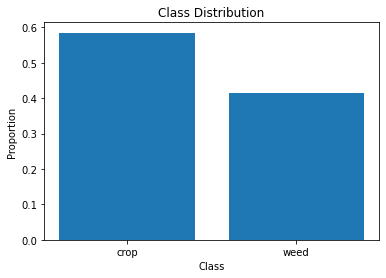

In [8]:
# Print the class distribution
class_dist = data['class'].value_counts(normalize=True)
print('Class distribution:\n', class_dist)

# Plot the class distribution
plt.bar(class_dist.index, class_dist.values)
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.title('Class Distribution')
plt.show()


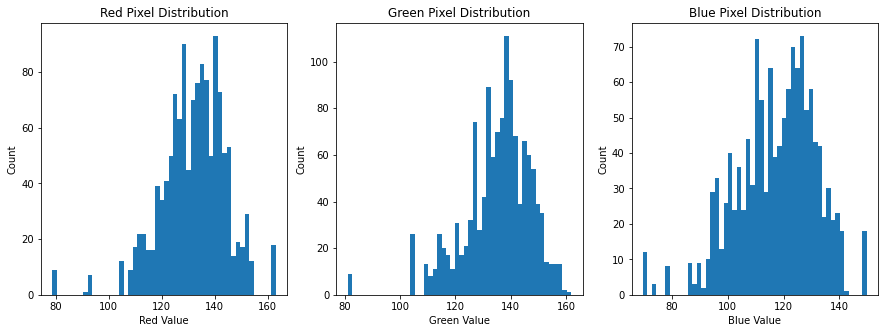

In [9]:
# get the image file paths
images = glob.glob('./dataset/data/*.jpeg')

# initialize the RGB value lists
r_vals = []
g_vals = []
b_vals = []

# loop through each image and get the RGB values
for i in range(len(images)):
    # read the image
    img = cv2.imread(images[i])
    
    # check if the image was read successfully
    if img is not None:
        # split the image into channels
        b, g, r = cv2.split(img)
        
        # calculate the mean of each channel
        r_mean = np.mean(r)
        g_mean = np.mean(g)
        b_mean = np.mean(b)
        
        # append the mean values to the RGB value lists
        r_vals.append(r_mean)
        g_vals.append(g_mean)
        b_vals.append(b_mean)
    else:
        print(f"Could not read image file: {images[i]}")

# plot the RGB distributions
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(r_vals, bins=50)
axs[0].set_xlabel('Red Value')
axs[0].set_ylabel('Count')
axs[0].set_title('Red Pixel Distribution')
axs[1].hist(g_vals, bins=50)
axs[1].set_xlabel('Green Value')
axs[1].set_ylabel('Count')
axs[1].set_title('Green Pixel Distribution')
axs[2].hist(b_vals, bins=50)
axs[2].set_xlabel('Blue Value')
axs[2].set_ylabel('Count')
axs[2].set_title('Blue Pixel Distribution')
plt.show()


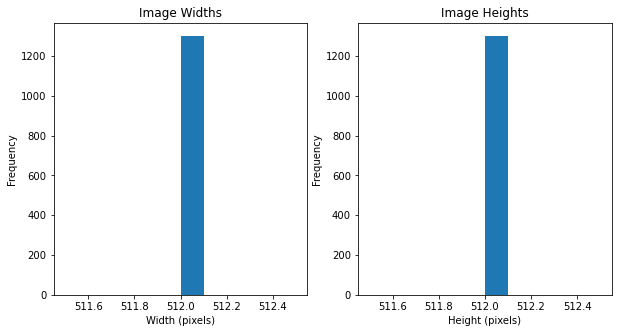

In [10]:
# Image dimension distribution
widths = []
heights = []

for img in images:
    with Image.open(img) as im:
        widths.append(im.width)
        heights.append(im.height)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(widths)
axs[0].set_title("Image Widths")
axs[0].set_xlabel("Width (pixels)")
axs[0].set_ylabel("Frequency")
axs[1].hist(heights)
axs[1].set_title("Image Heights")
axs[1].set_xlabel("Height (pixels)")
axs[1].set_ylabel("Frequency")
plt.show()

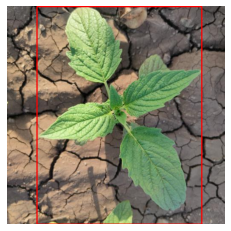

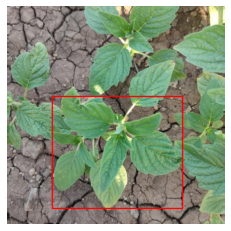

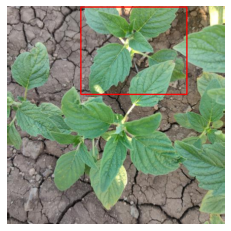

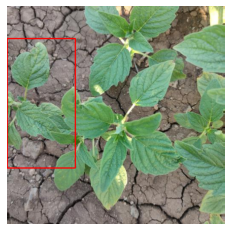

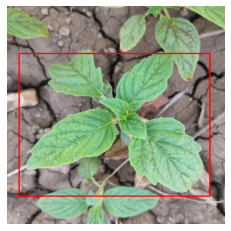

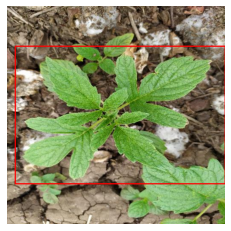

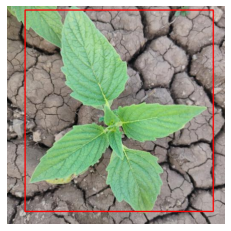

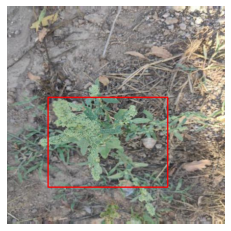

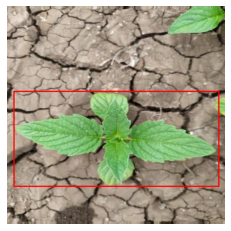

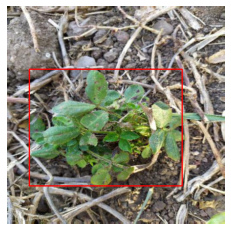

In [11]:
# Plot image with bounding box
def plot_image(image_path, xmin, ymin, xmax, ymax):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Visualize images with bounding boxes
for i in range(10):
    image_path = data.iloc[i]['filename']
    xmin = data.iloc[i]['xmin']
    ymin = data.iloc[i]['ymin']
    xmax = data.iloc[i]['xmax']
    ymax = data.iloc[i]['ymax']
    plot_image(image_path, xmin, ymin, xmax, ymax)


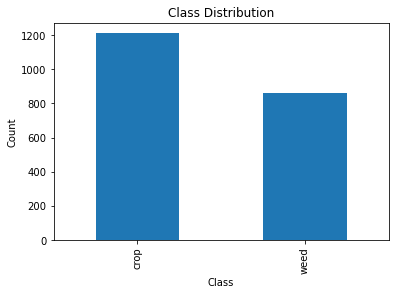

In [12]:
# Histogram of class distribution
class_counts = data['class'].value_counts()
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

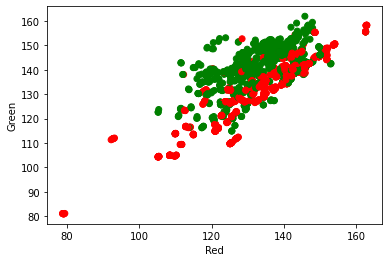

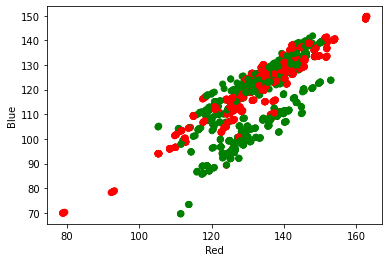

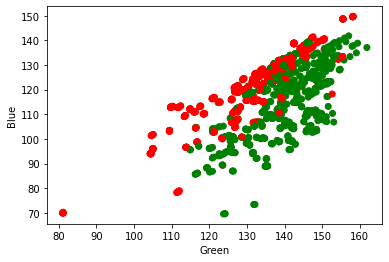

In [13]:
# Average color of images
def get_average_color(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    average_color = [image[:, :, i].mean() for i in range(3)]
    return average_color

data['average_color'] = data['filename'].apply(get_average_color)
data['red'] = data['average_color'].apply(lambda x: x[0])
data['green'] = data['average_color'].apply(lambda x: x[1])
data['blue'] = data['average_color'].apply(lambda x: x[2])

# RGB scatter plot with class labels
plt.scatter(data['red'], data['green'], c=data['class'].map({'crop': 'green', 'weed': 'red'}))
plt.xlabel('Red')
plt.ylabel('Green')
plt.show()

plt.scatter(data['red'], data['blue'], c=data['class'].map({'crop': 'green', 'weed': 'red'}))
plt.xlabel('Red')
plt.ylabel('Blue')
plt.show()

plt.scatter(data['green'], data['blue'], c=data['class'].map({'crop': 'green', 'weed': 'red'}))
plt.xlabel('Green')
plt.ylabel('Blue')
plt.show()

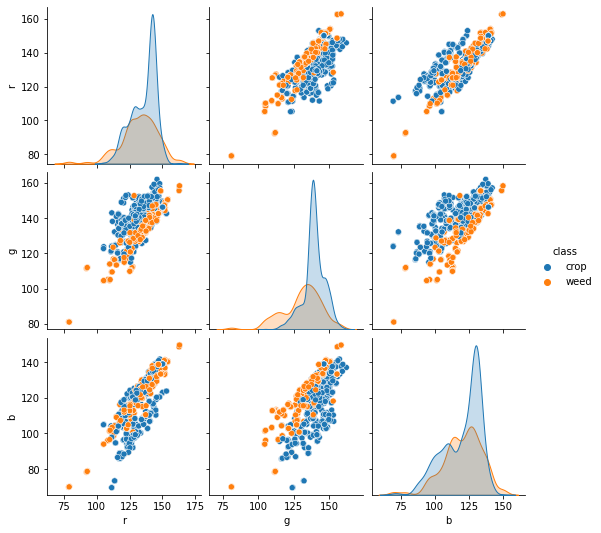

In [14]:
# Extract RGB color values from the images
rgb_values = []
for i, row in data.iterrows():
    image = plt.imread(row['filename'])
    r, g, b = image.mean(axis=0).mean(axis=0)
    rgb_values.append((r, g, b))

# Add RGB color values to the dataframe
data['r'] = [x[0] for x in rgb_values]
data['g'] = [x[1] for x in rgb_values]
data['b'] = [x[2] for x in rgb_values]

# Plot a pairplot based on the RGB color values and class labels
sns.pairplot(data, hue='class', vars=['r', 'g', 'b'])

### Quantitative Analysis

#### Class Distribution

Let's start by looking at the distribution of classes in the dataset:

The resulting plot will show the count of images for each class in the dataset. We can see how many images correspond to crops and how many correspond to weeds.

### Image Size Distribution

Another important factor to consider when analyzing image datasets is the size distribution of the images. We can use a jointplot from seaborn to visualize the distribution of image sizes:

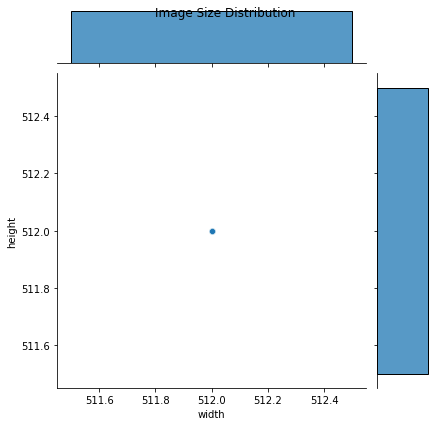

In [16]:
sns.jointplot(data=data, x='width', y='height')
plt.suptitle('Image Size Distribution')
plt.show()

This will create a scatter plot of the image sizes and also histograms showing the distribution of each dimension.

### Image Processing Techniques
#### Image Quality and Quality Factors

We can use image processing techniques to extract information about the quality of the images in the dataset. For example, we can calculate the image quality by multiplying the number of pixels by the mean pixel value:

In [17]:
def image_quality(row):
    img = imageio.imread(row['filename'])
    return img.shape[0] * img.shape[1] * statistics.mean(img.flatten())

data['image_quality'] = data.apply(image_quality, axis=1)

<ipython-input-17-f3a93a818de2>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(row['filename'])


We can also calculate the brightness, contrast, and entropy of the images using techniques such as histogram equalization and Fourier analysis. Here's an example of how to calculate these values:

In [18]:
def quality_factors(row):
    img = imageio.imread(row['filename'])
    brightness = np.mean(img)
    contrast = np.std(img)
    entropy = -np.sum(np.multiply(img, np.log2(img + (img == 0))))
    return brightness, contrast, entropy

data[['brightness', 'contrast', 'entropy']] = data.apply(quality_factors, axis=1, result_type='expand')

<ipython-input-18-ef5dcae42bb9>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(row['filename'])
/home/mnitin59/anaconda3/envs/aikit-pt/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


These values can then be used as additional features in a machine learning model, or to further analyze the image quality in the dataset.

Histograms and Density Plots:
Histograms and density plots can be used to visualize the distribution of continuous variables in your dataset, such as image quality, brightness, and contrast. They provide a way to easily see if the data is skewed or if there are any outliers.

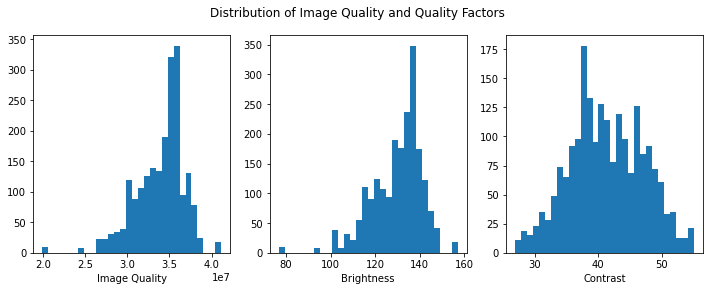

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].hist(data['image_quality'], bins=30)
axs[0].set_xlabel('Image Quality')

axs[1].hist(data['brightness'], bins=30)
axs[1].set_xlabel('Brightness')

axs[2].hist(data['contrast'], bins=30)
axs[2].set_xlabel('Contrast')

fig.suptitle('Distribution of Image Quality and Quality Factors')
plt.show()


Box Plots:
Box plots are another way to visualize the distribution of continuous variables, but they provide additional information such as quartiles, outliers, and the median.

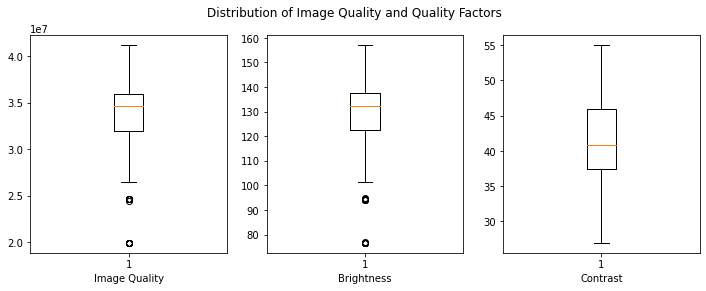

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].boxplot(data['image_quality'])
axs[0].set_xlabel('Image Quality')

axs[1].boxplot(data['brightness'])
axs[1].set_xlabel('Brightness')

axs[2].boxplot(data['contrast'])
axs[2].set_xlabel('Contrast')

fig.suptitle('Distribution of Image Quality and Quality Factors')
plt.show()


Scatter Plots:
Scatter plots can be used to visualize the relationship between two continuous variables, such as image width and height.

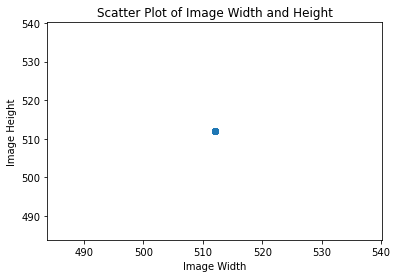

In [21]:
plt.scatter(data['width'], data['height'])
plt.xlabel('Image Width')
plt.ylabel('Image Height')
plt.title('Scatter Plot of Image Width and Height')
plt.show()


Heat Maps:
Heat maps can be used to visualize the relationship between two categorical variables, such as the class of the image and the number of images in each class.

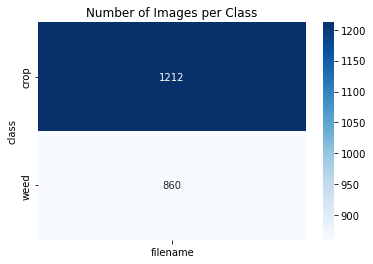

In [22]:
heatmap_data = pd.pivot_table(data, values='filename', index=['class'], aggfunc='count')
sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='g')
plt.title('Number of Images per Class')
plt.show()


Image Processing Techniques:
You can also use image processing techniques to visualize and analyze the images in your dataset. For example, you can plot the images and their bounding boxes to see how well the model is detecting the objects. 

In [23]:
# Define range of green color in HSV
lower_green = np.array([30, 50, 50])
upper_green = np.array([90, 255, 255])

imgpro_data = []

# Loop through the list of images
for i, row in data.iterrows():

    # Load RGB image
    img = cv2.imread(row['filename'])

    # Get bounding box coordinates
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

    # Add bounding box to original image
    img_with_box = img.copy()
    cv2.rectangle(img_with_box, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)

    # Crop image within bounding box and convert to HSV color space
    cropped_img = img[ymin:ymax, xmin:xmax]
    hsv = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2HSV)

    # Threshold the HSV image to get only green colors
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Apply K-means clustering to segment the image
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    attempts = 10
    ret, label, center = cv2.kmeans(np.float32(cropped_img.reshape(-1, 3)), K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)

    # Reshape label and mask to match cropped image size
    label = label.reshape(cropped_img.shape[0], cropped_img.shape[1])
    mask = cv2.resize(mask, (cropped_img.shape[1], cropped_img.shape[0]))

    # Apply mask to label array
    label[mask == 0] = 2  # Black for background
    label[mask != 0] -= 1  # 0 for weed, 1 for crop

    # Apply color map to label array
    label = cv2.applyColorMap(np.uint8(label), cv2.COLORMAP_VIRIDIS)

    # Apply mask to cropped image
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    result = cv2.bitwise_and(cropped_img, mask)
    
    imgpro_data.append([wandb.Image(Image.fromarray(img)), wandb.Image(img_with_box), wandb.Image(hsv), wandb.Image(mask), wandb.Image(label)])


In [24]:
table = pd.DataFrame(imgpro_data, columns=["Input Image", "Bounding Box Image", "HSV Image", "Mask Image", "Segmentation Image"])

In [28]:
wandb.init(project="Automated-Weed-Detection-AMP", entity=None)
wandb.log({"EDA Data": wandb.Table(data=data)})

In [25]:
wandb.init(project="Automated-Weed-Detection-AMP", entity=None)
wandb.log({"Raw Data": wandb.Table(data=table)})

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/mnitin59/.netrc


In [ ]:
wandb.init(project="Automated-Weed-Detection-AMP", entity=None)
wandb.log({"EDA Data": wandb.Table(data=data)})

In [26]:
table.to_csv('./dataset/imgpro_data.csv', index=False)

In [27]:
data.to_csv('./dataset/data.csv', index=False)

In [31]:
import os
import pandas as pd
import shutil

# Read the data file into a pandas dataframe
data = pd.read_csv("./dataset/data.csv")

# Create the base path for the images
image_path = "./dataset/data"

# Iterate through each row of the dataframe
for index, row in data.iterrows():
    # Get the filename and class of the current row
    filename = row['filename']
    classname = row['class']
    
    # Create the class folder if it doesn't already exist
    class_folder = os.path.join("./dataset/datafile", classname)
    if not os.path.exists(class_folder):
        os.makedirs(class_folder)
    
    # Copy the image from the filename to the class folder
    image_filename = os.path.basename(filename)
    image_src_path = os.path.join(image_path, image_filename)
    image_dest_path = os.path.join(class_folder, image_filename)
    shutil.copy(image_src_path, image_dest_path)
